In [2]:
import easydict
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import network
import matplotlib.pyplot as plt
import numpy as np

In [3]:
def imshow(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
#dv_images-args.epsilon, next_adv_images) Test phase
def visualize_adv_image(args, model, device, test_loader):
    model.eval()
    
    if args.model_parameter is not None:
        model.load_state_dict(torch.load(args.model_parameter))
    correct = 0
    adv_correct = 0
    misclassified = 0
    
    criterion = nn.CrossEntropyLoss()

    # because of image value [0, 1], args.epsilon * 255
    # number of iteration
    num_iter = int(min(args.epsilon*255 +4, 1.25*args.epsilon*255))
    print('number of adversarial example iteration :', num_iter)

    dataiter = iter(test_loader)
    images, targets = dataiter.next()
    images = Variable(images.to(device), requires_grad=True)
    targets = Variable(targets.to(device))
        
    origin_output = model(images)
    _, targets_LL = torch.min(origin_output.data, 1)

    # X_0 adv images
    adv_images = images
    for i in range(num_iter):
        outputs = model(adv_images)
        loss = criterion(outputs, targets_LL)
        loss.backward()

        # Generate perturbation
        grad_j = torch.sign(adv_images.grad.data)
        next_adv_images = adv_images - args.epsilon * grad_j
        lower_adv_images = torch.max(torch.tensor(0.).to(device), torch.max(adv_images-args.epsilon, next_adv_images))
        adv_images = torch.min(torch.tensor(1.).to(device), torch.min(adv_images+args.epsilon, lower_adv_images))
        adv_images = Variable(adv_images.to(device), requires_grad=True)
    print('original image')
    imshow(torchvision.utils.make_grid(images, ))
    print('adversarial image')
    imshow(torchvision.utils.make_grid(adv_images, ))

In [11]:
def main():
    args = easydict.EasyDict({
      'test_batch_size': 32,
      'epochs': 10,
      'lr': 0.001,
      'gamma': 0.06,
      'no_cuda': True,
      'epsilon': 0.05,
      'model_parameter': './model/l_l_model-20.ckpt' 
    })
    

    use_cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")
    transformation = transforms.ToTensor()

    test_loader = torch.utils.data.DataLoader(
      datasets.CIFAR10('./data', train=False, download=True,
                        transform=transformation),
      batch_size=args.test_batch_size, shuffle=True)
  
    model = network.GoogLeNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)
    
    visualize_adv_image(args, model, device, test_loader)

Files already downloaded and verified
number of adversarial example iteration : 15
original image


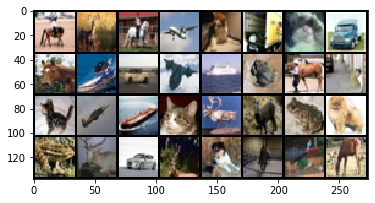

adversarial image


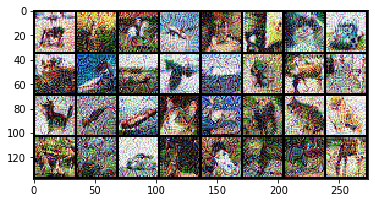

In [12]:
if __name__ == '__main__':
    main()    